# Feature Engineering Exploration
# 
# Task 3: Feature Engineering for Credit Risk Model
# 
# Objective: Explore and test feature engineering transformations before implementing in production code.
# 
# Approach:
# 1. Load and explore data
# 2. Test RFM calculations
# 3. Test temporal feature extraction
# 4. Test categorical encoding strategies
# 5. Create and test sklearn pipeline
# 6. Export best transformations to production code


## 1. Setup dependencies

In [1]:
print("jenjtg")

jenjtg


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


# Load the data

In [3]:
data_path = "../data/raw/data.csv"
df = pd.read_csv(data_path)

# Convert date column
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'])

print(f"📊 Data loaded: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"📅 Date range: {df['TransactionStartTime'].min()} to {df['TransactionStartTime'].max()}")

# Display sample
df.head()

📊 Data loaded: 95,662 rows, 16 columns
📅 Date range: 2018-11-15 02:18:49+00:00 to 2019-02-13 10:01:28+00:00


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.000,1000,2018-11-15 02:18:49+00:00,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.000,20,2018-11-15 02:19:08+00:00,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.000,500,2018-11-15 02:44:21+00:00,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.000,21800,2018-11-15 03:32:55+00:00,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.000,644,2018-11-15 03:34:21+00:00,2,0


# 2. RFM Feature Engineering Test


In [4]:
# Calculate RFM metrics manually first
snapshot_date = df['TransactionStartTime'].max()  # Last transaction date

# Group by customer
rfm_df = df.groupby('CustomerId').agg({
    'TransactionStartTime': lambda x: (snapshot_date - x.max()).days,  # Recency
    'TransactionId': 'count',  # Frequency
    'Amount': ['sum', 'mean', 'std']  # Monetary
}).reset_index()

# Flatten column names
rfm_df.columns = ['CustomerId', 'recency_days', 'transaction_count', 
                  'total_amount', 'avg_transaction_amount', 'std_transaction_amount']

# Fill NaN for std (customers with only one transaction)
rfm_df['std_transaction_amount'] = rfm_df['std_transaction_amount'].fillna(0)

# Add log transform for monetary
rfm_df['log_total_amount'] = np.log1p(rfm_df['total_amount'].abs())

print("📈 RFM Metrics Calculated:")
print(f"   Number of customers: {len(rfm_df):,}")
print(f"   Features created: {len(rfm_df.columns) - 1}")

# Display RFM statistics
rfm_df.describe()

📈 RFM Metrics Calculated:
   Number of customers: 3,742
   Features created: 6


,recency_days,transaction_count,total_amount,avg_transaction_amount,std_transaction_amount,log_total_amount
count,3742.000,3742.000,3742.000,3742.000,3742.000,3742.000
mean,30.461,25.564,171737.741,15715.616,13605.166,9.895
std,27.119,96.930,2717304.824,167699.098,96893.438,2.126
min,0.000,1.000,-104900000.000,-425000.000,0.000,0.000
25%,5.000,2.000,4077.438,1000.000,501.141,8.517
50%,24.000,7.000,20000.000,2583.846,3184.898,9.904
75%,53.000,20.000,79967.750,4877.614,6745.369,11.290
max,90.000,4091.000,83451240.000,8601821.143,3309916.124,18.469


# Visualize RFM distributions

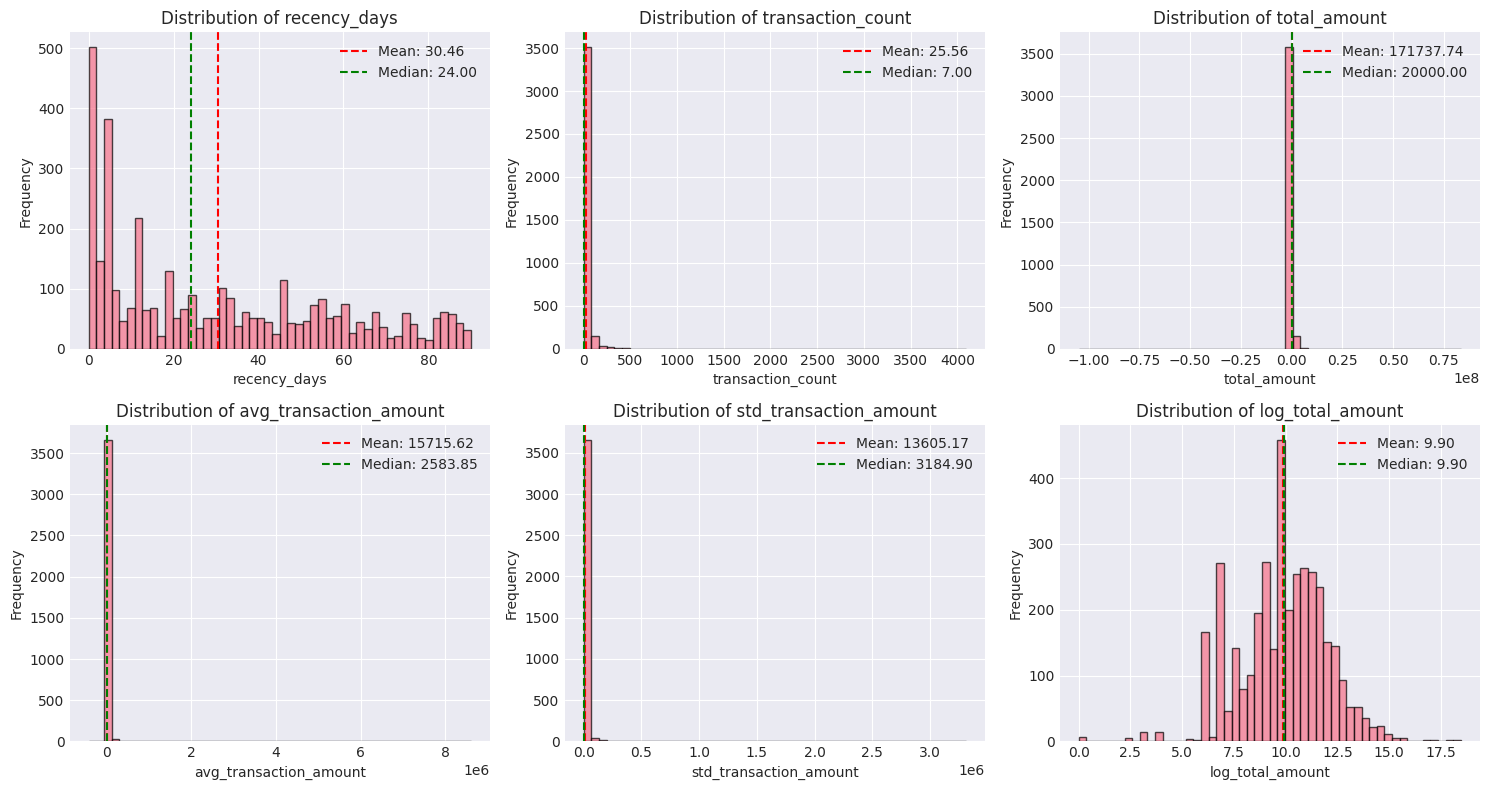

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

rfm_metrics = ['recency_days', 'transaction_count', 'total_amount', 
               'avg_transaction_amount', 'std_transaction_amount', 'log_total_amount']

for idx, metric in enumerate(rfm_metrics[:6]):
    axes[idx].hist(rfm_df[metric].dropna(), bins=50, edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Distribution of {metric}')
    axes[idx].set_xlabel(metric)
    axes[idx].set_ylabel('Frequency')
    
    # Add statistics
    mean_val = rfm_df[metric].mean()
    median_val = rfm_df[metric].median()
    axes[idx].axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
    axes[idx].axvline(median_val, color='green', linestyle='--', label=f'Median: {median_val:.2f}')
    axes[idx].legend()

plt.tight_layout()
plt.show()

# 3. Temporal Feature Extraction Test

🕒 Temporal Features Created: 12
Features: ['transaction_hour', 'transaction_day', 'transaction_month', 'transaction_year', 'transaction_dayofweek', 'transaction_weekofyear', 'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 'is_business_hours', 'is_weekend']


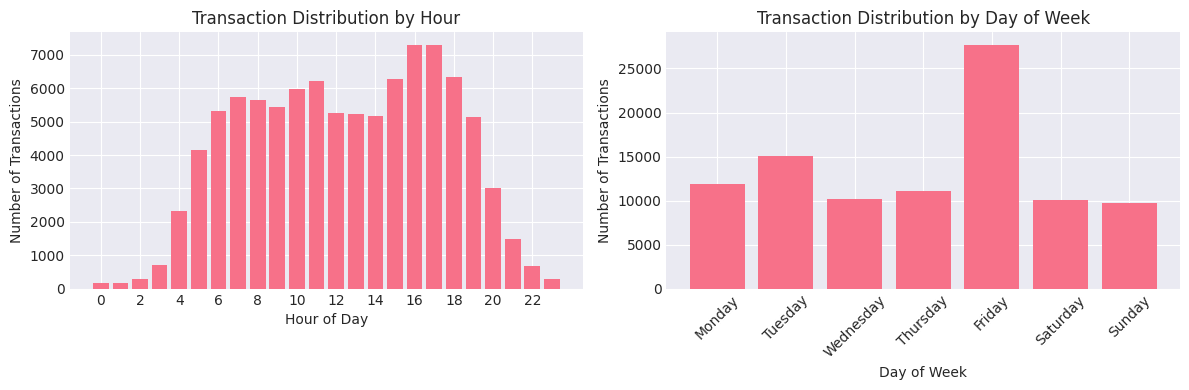

In [6]:
# Extract temporal features
df_temp = df.copy()

# Basic temporal features
df_temp['transaction_hour'] = df_temp['TransactionStartTime'].dt.hour
df_temp['transaction_day'] = df_temp['TransactionStartTime'].dt.day
df_temp['transaction_month'] = df_temp['TransactionStartTime'].dt.month
df_temp['transaction_year'] = df_temp['TransactionStartTime'].dt.year
df_temp['transaction_dayofweek'] = df_temp['TransactionStartTime'].dt.dayofweek
df_temp['transaction_weekofyear'] = df_temp['TransactionStartTime'].dt.isocalendar().week

# Cyclical features (for hour and day of week)
df_temp['hour_sin'] = np.sin(2 * np.pi * df_temp['transaction_hour']/24)
df_temp['hour_cos'] = np.cos(2 * np.pi * df_temp['transaction_hour']/24)
df_temp['dayofweek_sin'] = np.sin(2 * np.pi * df_temp['transaction_dayofweek']/7)
df_temp['dayofweek_cos'] = np.cos(2 * np.pi * df_temp['transaction_dayofweek']/7)

# Business features
df_temp['is_business_hours'] = df_temp['transaction_hour'].between(9, 17).astype(int)
df_temp['is_weekend'] = df_temp['transaction_dayofweek'].isin([5, 6]).astype(int)

# Display temporal features created
temporal_features = [col for col in df_temp.columns if 'transaction' in col or 'hour' in col 
                     or 'day' in col or 'week' in col or 'month' in col]
print(f"🕒 Temporal Features Created: {len(temporal_features)}")
print("Features:", temporal_features)

# Show distribution of hour and day
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Hour distribution
hour_counts = df_temp['transaction_hour'].value_counts().sort_index()
axes[0].bar(hour_counts.index, hour_counts.values)
axes[0].set_title('Transaction Distribution by Hour')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Number of Transactions')
axes[0].set_xticks(range(0, 24, 2))

# Day of week distribution
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = df_temp['transaction_dayofweek'].value_counts().sort_index()
axes[1].bar(day_counts.index, day_counts.values)
axes[1].set_title('Transaction Distribution by Day of Week')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Number of Transactions')
axes[1].set_xticks(range(7))
axes[1].set_xticklabels(day_names, rotation=45)

plt.tight_layout()
plt.show()

# 4. Categorical Encoding Test

In [7]:
# Explore categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in 
                    ['TransactionId', 'CustomerId', 'AccountId', 'SubscriptionId', 'BatchId']]

print("🔤 Categorical Columns Found:")
for col in categorical_cols:
    unique_count = df[col].nunique()
    top_values = df[col].value_counts().head(3).to_dict()
    print(f"  • {col}: {unique_count} unique values")
    print(f"    Top values: {top_values}")
    # Test different encoding strategies
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from category_encoders import WOEEncoder
import category_encoders as ce

# Select a categorical column for testing
test_col = 'ProductCategory'

print(f"🔧 Testing Encoding Strategies for '{test_col}':")
print("=" * 50)

# Original distribution
print("\n1. Original Distribution:")
print(df[test_col].value_counts().head())

# %%
# Test Label Encoding
print("\n2. Label Encoding:")
le = LabelEncoder()
df_label = df.copy()
df_label[f'{test_col}_label'] = le.fit_transform(df_label[test_col].astype(str))
print("Encoded values:", dict(zip(le.classes_, le.transform(le.classes_))))
print("Sample encoded data:")
print(df_label[[test_col, f'{test_col}_label']].head())

# %%
# Test One-Hot Encoding (for top N categories)
print("\n3. One-Hot Encoding (Top 5 categories):")
top_categories = df[test_col].value_counts().head(5).index.tolist()

# Create binary columns for top categories
for category in top_categories:
    df[f'is_{category}'] = (df[test_col] == category).astype(int)

print("Created columns:", [f'is_{cat}' for cat in top_categories])
print("Sample one-hot encoded data:")
print(df[['ProductCategory'] + [f'is_{cat}' for cat in top_categories]].head())

# %%
# Note: WOE Encoding requires target variable
# We'll test this in Task 4 when we have the target
print("\n4. WOE Encoding:")
print("⚠️  Requires target variable - Will test in Task 4 after creating proxy target")

# %%
# Information Value (IV) calculation for feature selection
def calculate_iv(df, feature, target):
    """
    Calculate Information Value for a feature
    IV < 0.02: Not useful
    0.02 <= IV < 0.1: Weak predictor
    0.1 <= IV < 0.3: Medium predictor
    IV >= 0.3: Strong predictor
    """
    # We'll implement this in Task 4 with target
    pass

print("\n📊 Information Value (IV) Analysis:")
print("Will calculate in Task 4 after creating target variable")


🔤 Categorical Columns Found:
  • CurrencyCode: 1 unique values
    Top values: {'UGX': 95662}
  • ProviderId: 6 unique values
    Top values: {'ProviderId_4': 38189, 'ProviderId_6': 34186, 'ProviderId_5': 14542}
  • ProductId: 23 unique values
    Top values: {'ProductId_6': 32635, 'ProductId_3': 24344, 'ProductId_10': 15384}
  • ProductCategory: 9 unique values
    Top values: {'financial_services': 45405, 'airtime': 45027, 'utility_bill': 1920}
  • ChannelId: 4 unique values
    Top values: {'ChannelId_3': 56935, 'ChannelId_2': 37141, 'ChannelId_5': 1048}
🔧 Testing Encoding Strategies for 'ProductCategory':

1. Original Distribution:
ProductCategory
financial_services    45405
airtime               45027
utility_bill           1920
data_bundles           1613
tv                     1279
Name: count, dtype: int64

2. Label Encoding:
Encoded values: {'airtime': np.int64(0), 'data_bundles': np.int64(1), 'financial_services': np.int64(2), 'movies': np.int64(3), 'other': np.int64(4), 'tic

# 5. Sklearn Pipeline Creation Test

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer

# Create a simple test pipeline
print("🧪 Testing Sklearn Pipeline Creation")

# Define a custom transformer for RFM
from sklearn.base import BaseEstimator, TransformerMixin

class SimpleRFMTransformer(BaseEstimator, TransformerMixin):
    """Simple RFM transformer for testing"""
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        # Simplified RFM for testing
        if 'TransactionStartTime' in X_copy.columns and 'Amount' in X_copy.columns:
            # This is simplified - real implementation in src/data_processing.py
            pass
        return X_copy

# Create pipeline steps
pipeline_steps = [
    ('rfm', SimpleRFMTransformer()),
    # Add more steps as needed
]

# Create pipeline
test_pipeline = Pipeline(pipeline_steps)

print("✅ Pipeline created successfully")
print(f"Pipeline steps: {test_pipeline.named_steps.keys()}")

🧪 Testing Sklearn Pipeline Creation
✅ Pipeline created successfully
Pipeline steps: dict_keys(['rfm'])


# 6. Complete Feature Set Creation

In [9]:
# Combine all features into a complete dataset
print("🔗 Creating Complete Feature Set")

# Merge RFM features with original data
df_with_features = df.merge(rfm_df, on='CustomerId', how='left')

# Add temporal features (already in df_temp)
for col in temporal_features:
    if col in df_temp.columns and col not in df_with_features.columns:
        df_with_features[col] = df_temp[col]

# Add one-hot encoded categorical features
for category in top_categories:
    df_with_features[f'is_{category}'] = df[f'is_{category}']

# Display final feature set
print(f"📊 Final dataset shape: {df_with_features.shape}")
print(f"🎯 Total features created: {df_with_features.shape[1] - len(df.columns) + 1}")

# Separate feature types
feature_types = {
    'Original Features': len(df.columns),
    'RFM Features': len(rfm_df.columns) - 1,  # Exclude CustomerId
    'Temporal Features': len(temporal_features),
    'Categorical Encodings': len(top_categories)  # One-hot features
}

print("\n📈 Feature Breakdown:")
for feature_type, count in feature_types.items():
    print(f"  • {feature_type}: {count}")

# Show sample of new features
new_features = [col for col in df_with_features.columns if col not in df.columns]
print(f"\n🔍 New features (first 10): {new_features[:10]}...")

# Display correlation of new features with Amount (as example)
if 'Amount' in df_with_features.columns:
    numeric_features = df_with_features[new_features].select_dtypes(include=[np.number]).columns
    correlations = df_with_features[numeric_features].corrwith(df_with_features['Amount']).abs().sort_values(ascending=False)
    
    print("\n📊 Correlation with Transaction Amount (Top 10):")
    print(correlations.head(10))

🔗 Creating Complete Feature Set
📊 Final dataset shape: (95662, 39)
🎯 Total features created: 19

📈 Feature Breakdown:
  • Original Features: 21
  • RFM Features: 6
  • Temporal Features: 12
  • Categorical Encodings: 5

🔍 New features (first 10): ['recency_days', 'transaction_count', 'total_amount', 'avg_transaction_amount', 'std_transaction_amount', 'log_total_amount', 'transaction_hour', 'transaction_day', 'transaction_month', 'transaction_year']...

📊 Correlation with Transaction Amount (Top 10):
avg_transaction_amount   0.695
std_transaction_amount   0.476
total_amount             0.117
transaction_count        0.058
log_total_amount         0.052
hour_cos                 0.014
transaction_year         0.011
recency_days             0.010
is_business_hours        0.010
transaction_month        0.009
dtype: float64


# 7. Export Best Practices to Production Code

In [10]:
print("🚀 Exporting Insights to Production Code")

insights = {
    'rfm_insights': {
        'recency_days_stats': rfm_df['recency_days'].describe().to_dict(),
        'transaction_count_stats': rfm_df['transaction_count'].describe().to_dict(),
        'recommended_features': list(rfm_df.columns[1:])  # Exclude CustomerId
    },
    'temporal_insights': {
        'peak_hour': int(df_temp['transaction_hour'].mode()[0]),
        'peak_day': int(df_temp['transaction_dayofweek'].mode()[0]),
        'business_hours_percentage': df_temp['is_business_hours'].mean() * 100,
        'recommended_features': temporal_features[:10]  # First 10 temporal features
    },
    'categorical_insights': {
        'high_cardinality_cols': [col for col in categorical_cols if df[col].nunique() > 50],
        'low_cardinality_cols': [col for col in categorical_cols if df[col].nunique() <= 10],
        'top_categories_by_column': {col: df[col].value_counts().head(3).index.tolist() 
                                     for col in categorical_cols[:3]}
    },
    'pipeline_recommendations': {
        'encoding_strategy': 'woe_for_high_importance, onehot_for_low_cardinality',
        'scaling_needed': True,
        'feature_selection_recommended': True
    }
}

print("✅ Insights captured for production code implementation")
print("\nKey recommendations for src/data_processing.py:")
print("1. Use these RFM features:", insights['rfm_insights']['recommended_features'])
print("2. Include these temporal features:", insights['temporal_insights']['recommended_features'])
print("3. Handle categorical columns with mixed strategy")
print("4. Implement sklearn Pipeline with ColumnTransformer")

# Save insights to JSON for reference
import json
with open('../data/processed/feature_insights.json', 'w') as f:
    json.dump(insights, f, indent=2)

print("\n💾 Insights saved to data/processed/feature_insights.json")

🚀 Exporting Insights to Production Code
✅ Insights captured for production code implementation

Key recommendations for src/data_processing.py:
1. Use these RFM features: ['recency_days', 'transaction_count', 'total_amount', 'avg_transaction_amount', 'std_transaction_amount', 'log_total_amount']
2. Include these temporal features: ['transaction_hour', 'transaction_day', 'transaction_month', 'transaction_year', 'transaction_dayofweek', 'transaction_weekofyear', 'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos']
3. Handle categorical columns with mixed strategy
4. Implement sklearn Pipeline with ColumnTransformer

💾 Insights saved to data/processed/feature_insights.json


# 8. Next Steps for Production Implementation

In [11]:
print("📋 Next Steps for Task 3 Completion:")

next_steps = [
    "✅ 1. Feature exploration completed in this notebook",
    "➡️  2. Implement RFMCalculator class in src/data_processing.py",
    "➡️  3. Implement TemporalFeatureExtractor class",
    "➡️  4. Implement CategoricalEncoder with WOE support",
    "➡️  5. Create sklearn Pipeline combining all transformers",
    "➡️  6. Add unit tests for each component",
    "➡️  7. Run pipeline on full dataset",
    "➡️  8. Save processed features for Task 4"
]

for step in next_steps:
    print(f"  {step}")

print("\n🎯 Ready to implement production code in src/data_processing.py!")

📋 Next Steps for Task 3 Completion:
  ✅ 1. Feature exploration completed in this notebook
  ➡️  2. Implement RFMCalculator class in src/data_processing.py
  ➡️  3. Implement TemporalFeatureExtractor class
  ➡️  4. Implement CategoricalEncoder with WOE support
  ➡️  5. Create sklearn Pipeline combining all transformers
  ➡️  6. Add unit tests for each component
  ➡️  7. Run pipeline on full dataset
  ➡️  8. Save processed features for Task 4

🎯 Ready to implement production code in src/data_processing.py!
